## Getting Data from an API - The Met Museum (REST API)


This notebook is designed to work in a stepwise manner to build an understanding for programmatically making an API request, the various considerations and possibilities. This is a pre-prepared workbook, and follows some stepwise options and examples for demonstrative purposes. With an increased familiarity with your own domain, ways of working, and goals, it aims to show a variety of steps a user can take but is not an exhaustive programme.

The notebook is split into 3 sections and we will work through in a stepwise manner. The images for the API use in the notebook are from the Met Museum documentation.

> Important notes about this notebook
- Talks to a live external API (The Met),
- And then fetches live external images (another host/CDN),
- Environment/IP differences for images (Noteable vs home machine vs Colab vs Kaggle, etc. → 403 variability).

**Search 1**

In [ ]:
# These are some of the required imports for the session
import requests              # For sending HTTP requests to the API
import json                  # For working with JSON responses
from pathlib import Path     # For file/directory path handling
import pandas as pd          # For working with tabular data
import pprint                # For readable display of nested JSON objects and other printed items
import time                  # Adding time delay when we get data from the API
from collections import Counter #counting things
import matplotlib.pyplot as plt #making a visualisation
from wordcloud import WordCloud
# !pip install requests pandas
# !pip install wordcloud

----------------------------------------------SECTION 1--------------------------------------------------

Now that important features and libraries are imported and we have them ready, we can start a request process with the Met Museum API. Starting simple and adding new elements as we work though the code book.

*What is this code block doing?*
1. Base URL:
https://collectionapi.metmuseum.org/public/collection/v1/ is the **root** for all API access.
2. Endpoint /search:
This is used to find object IDs based on keywords. The URL becomes:
https://collectionapi.metmuseum.org/public/collection/v1/search 
- Note the addition of **search** in the URL
3. Query parameters is **'q'** in the code block. Additionally 'hasImages' was included to ensure that items with images are included in the parameters.
- > Note: after some exploration, it it became apparent that removing this element draws on less results '96', this is interesting and may be related to image data generally having fuller records or fuller metadata. A consideration when making the search, to be precise where there are specific aims.
4. We check the status code
5. Inspecting what we have and printing out some details to check before we proceed.

All the sentences in green with a **#** are annotations we have added to explain the code block and what is being executed.

In [2]:
# Define the search term - lets say we want to search items related to this term
search_term = "sunflowers" #### search term is defined by us, you can call it anything, keyword, search or other, it is set out here so we can use it later without verbose labels.
#We use it below in the query parameters 'q' and our term 'sunflowers' is saved in there. We chose to use search_terms since it is easy to understand.

# Define the MET API endpoint and search parameters
search_url = "https://collectionapi.metmuseum.org/public/collection/v1/search"
params = {
    "q": search_term, # 'q' is the query parameter used by the MET API documentation for keyword searches
    "hasImages": "true" # Only return objects that have associated images, can remove this if not of interest.
}

# Send a GET request to the MET API - this will get the object IDs from our search and we can save those
response = requests.get(search_url, params=params)

#Check HTTP response status code
# Most REST APIs return a status code:
# 200 = OK, 400+ = error, e.g. 404 = not found
print("Status code:", response.status_code)

# Convert the response to JSON format (Python dictionary)
search_data_1 = response.json() #Now we have the json converted to a dictionary to examine, we call in search_data_1 to keep it identifiable for this stage. Note: We haven't save it, just inspecting and using to build our query up.
#MET API returns a list of matching objectIDs in the response JSON, objectID is a documented feature of the MET API, we will inspect this in the later steps.

## A BREAKDOWN OF OUTPUTS FROM OUR STEPS SO FAR--->

#This response is a simple search output that we got back as a JSON, it contains two items here, the total and the object ID. We can now use this information for our further queries.
print(search_data_1.keys())

# Preview how many items were returned by the API
print("Total results found:", search_data_1.get("total"))

# Display all object IDs returned from the search
print("Object IDs returned:", search_data_1.get("objectIDs", []))



Status code: 200
dict_keys(['total', 'objectIDs'])
Total results found: 133
Object IDs returned: [437112, 551786, 729644, 472562, 317877, 329077, 310453, 437422, 206965, 459027, 459028, 544320, 200668, 544740, 854970, 435848, 824771, 436102, 192770, 438821, 53660, 437261, 460281, 453385, 194191, 452102, 816522, 207157, 237451, 450605, 549236, 451725, 438779, 53162, 435997, 464294, 712539, 435864, 820022, 838076, 436884, 436885, 39901, 852562, 437368, 436529, 437984, 435897, 776714, 436098, 816189, 439327, 204587, 197461, 197460, 437061, 448280, 437173, 844492, 383883, 485416, 437202, 334030, 811771, 811772, 687615, 377933, 436099, 464273, 452032, 76034, 437059, 436144, 430812, 850659, 347927, 736196, 437216, 626692, 435621, 759529, 822751, 448959, 822560, 437868, 452740, 40080, 435702, 436658, 488221, 436530, 888663, 436803, 435844, 36225, 764636, 39742, 437585, 228995, 499559, 437878, 60470, 436534, 437384, 464132, 452364, 228990, 200840, 53238, 436838, 437980, 452651, 201718, 436607,

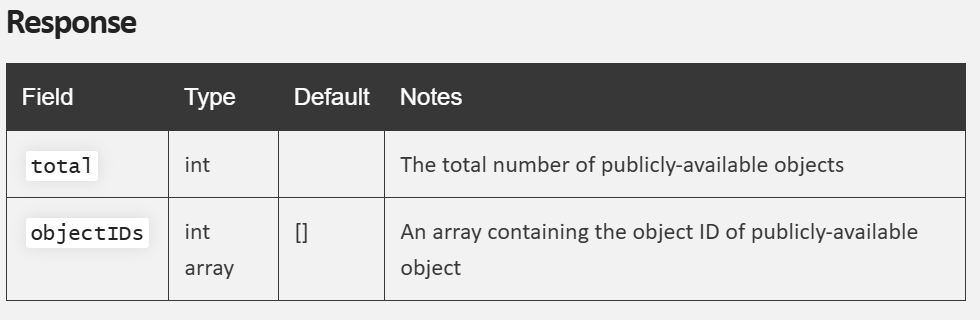

The output view shows the layers of information we have from the simple search so far. 

We sent a search request to the MET Collection API using the `requests` library.

- We specify a keyword in **search_term** (`sunflowers`).
- The API returns a list of object IDs that match our query.
- We checked the status code and it was 200 which means the search was successful.
- We'll use the IDs to get the metadata in the next step.

In [3]:
# Save the search JSON - search_1 - so that we have it for traceability.

# Where do we save it--->
metadata_dir = Path("Metadata")

#This is based on the file structure used in this repository where we save outputs in different folders outside of the notebooks folder.

# Save the initial search JSON
search_output_path = metadata_dir / "sunflowers_search_data_1.json"
with open(search_output_path, "w", encoding="utf-8") as f:
    json.dump(search_data_1, f, indent=2)

#This initial search is saved with the suffix **search data 1** assigned by us for tracing. 


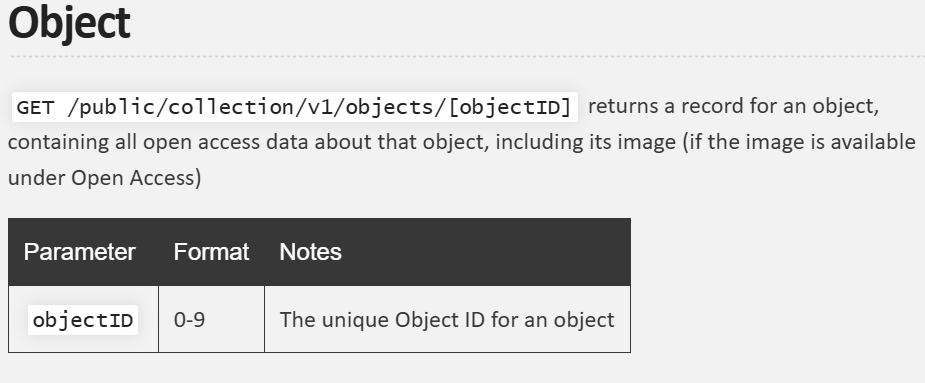

Now we have the object IDs matching for the item we searched, we can setup a URL to get the associated metadata for specified object. Starting with just one object to demonstrate the steps:

We can now make the request to get the full metadata for this object and print out some of the included metadata to see whats there:
When setting up inputs and outputs, the naming convention we use is wordy but helps for clarity, for example specifying search_1 and so forth. This helps whilst we are working in the 
same notebook and keeping some clarity in our outputs.

- Inspecting the metadata JSON for a single object

In [4]:
# Get the first Object ID from the search results
first_example_id = search_data_1.get("objectIDs", [])[0] #we take the first ID from the list we obtained earlier, in python this would start at point 0 for the FIRST item.


# Build the URL to get full metadata for this object
object_url_search1 = f"https://collectionapi.metmuseum.org/public/collection/v1/objects/{first_example_id}"
object_response_search1 = requests.get(object_url_search1)
object_data_search1 = object_response_search1.json()

#Check HTTP response status code
# Most REST APIs return a status code:
# 200 = OK, 400+ = error, e.g. 404 = not found
print("Status code:", response.status_code)

#Let's see which fields are available - Preview the full metadata structure
import pprint
pprint.pprint(object_data_search1) #Pretty print the full metadata so we can explore available fields
# the output below is scrollable, and you can see all the available metadata for the one item (ID: 437112) below.


Status code: 200
{'GalleryNumber': '819',
 'accessionNumber': '29.100.107',
 'accessionYear': '1929',
 'additionalImages': [],
 'artistAlphaSort': 'Monet, Claude',
 'artistBeginDate': '1840',
 'artistDisplayBio': 'French, Paris 1840–1926 Giverny',
 'artistDisplayName': 'Claude Monet',
 'artistEndDate': '1926',
 'artistGender': '',
 'artistNationality': 'French',
 'artistPrefix': '',
 'artistRole': 'Artist',
 'artistSuffix': '',
 'artistULAN_URL': 'http://vocab.getty.edu/page/ulan/500019484',
 'artistWikidata_URL': 'https://www.wikidata.org/wiki/Q296',
 'city': '',
 'classification': 'Paintings',
 'constituents': [{'constituentID': 162135,
                   'constituentULAN_URL': 'http://vocab.getty.edu/page/ulan/500019484',
                   'constituentWikidata_URL': 'https://www.wikidata.org/wiki/Q296',
                   'gender': '',
                   'name': 'Claude Monet',
                   'role': 'Artist'}],
 'country': '',
 'county': '',
 'creditLine': 'H. O. Havemeyer Col

Scrolling down in the output will show that the first object ID was 437112 and a number of features of metadata are available for that object

We can select a few of the items to display and look at here in the codebook

In [5]:
# Choosing some items to check and print here for review
# Display a few key fields that we are interested in
print("Title:", object_data_search1.get("title"))
print("Artist:", object_data_search1.get("artistDisplayName"))
print("Date:", object_data_search1.get("objectDate"))
print("Medium:", object_data_search1.get("medium"))

Title: Bouquet of Sunflowers
Artist: Claude Monet
Date: 1881
Medium: Oil on canvas


It is useful to save this JSON output locally if we were to proceed with the response we got back. In this case we only have one item, but later we will explore others and you may want to keep a record of processes.

In [6]:
metadata_path = Path("Metadata") / f"{first_example_id}_FirstExample_metadata.json"

with open(metadata_path, "w", encoding="utf-8") as f:
    json.dump(object_data_search1, f, indent=2)

## Processing the data for use

There are a number of ways a user might want to work with all the metadata stored in the JSON file. Exploratory look, extraction of key features, and the use here depends on the goal. For this section with just 1 example, we have only metadata for a single object for demonstrative purposes. We will export the key elements of interest into csv tabular format to explore how it lays out, for demonstrative purposes. In later stages where we increase the size of the metadata or images that we collect, we may want to preserve features of the nested JSON structure, combine outputs or convert subsets of data to CSV to clean and sort the data for dedicated use in a project.

Despite this being limited to 1 object, there is enough richness in the metadata to extract and view.
An example of extracting and viewing is shown below

In [7]:
# Load the correct JSON file
json_path = Path("Metadata/437112_FirstExample_metadata.json")
with open(json_path, "r", encoding="utf-8") as f:
    search1_object_metadata = json.load(f)


# Extract key metadata fields
search1_first_example_summary = {
    "Object ID": search1_object_metadata.get("objectID"),
    "Title": search1_object_metadata.get("title"),
    "Artist": search1_object_metadata.get("artistDisplayName"),
    "Artist Bio": search1_object_metadata.get("artistDisplayBio"),
    "Date": search1_object_metadata.get("objectDate"),
    "Medium": search1_object_metadata.get("medium"),
    "Dimensions": search1_object_metadata.get("dimensions"),
    "Department": search1_object_metadata.get("department"),
    "Classification": search1_object_metadata.get("classification"),
    "Repository": search1_object_metadata.get("repository"),
    "Credit Line": search1_object_metadata.get("creditLine"),
    "Public Domain": search1_object_metadata.get("isPublicDomain"),
    "Object URL": search1_object_metadata.get("objectURL"),
    "Image URL": search1_object_metadata.get("primaryImageSmall"),
    "Tags": ", ".join([tag["term"] for tag in search1_object_metadata.get("tags", [])]),
    "Artist Wikidata": search1_object_metadata.get("artistWikidata_URL"),
    "Object Wikidata": search1_object_metadata.get("objectWikidata_URL"),
}

# Save to CSV using utf-8-sig encoding
csv_path = Path("Converted_Data/437112_FirstExample_metadata.csv")###this is where the file is for the single object.

df = pd.DataFrame([search1_first_example_summary]) ###what we do here is to create a dataframe to export into csv
#tabular formats. We do not save the dataframe in this section since it is a minimal example. More on that later.
df.to_csv(csv_path, index=False, encoding="utf-8-sig")


We have now extract selected fields from the saved JSON and convert them to a tabular format (CSV). This allows us to:

- View and analyse the data in a recognised format
- Use it in other tools (Excel, R, etc.)

We use `.get()` to safely retrieve fields, even if they’re missing. The encoding is set to `utf-8-sig` for compatibility with spreadsheet applications like Excel.

 > Option - take a look in the 'Converted_Data' folder for the CSV and have a look at the items exported into that file. For the single object ID and its related metadata. The data is stored in an orderly manner, however some cells include multiple words and features. This is where data pre-processing would be important if using these data as structured corpora or as the base for an analysis

----------------------------------------SECTION 2---------------------------------------------------------

## From a single item to a small batch & images (if available)

**Search 2**

In [8]:
# These are some of the required imports for the session
import requests              # For sending HTTP requests to the API
import json                  # For working with JSON responses
from pathlib import Path     # For safe file/directory path handling
import pandas as pd          # For working with tabular data
import pprint                # For readable display of nested JSON objects
import time                  # Adding time delay
from collections import Counter
# !pip install requests pandas

Let's try something different and curate a little bit what we do with the object IDs returned from the API by a given keyword, and carefully select a larger number of items to work with. This section will query the API about the key word 'calligraphy' and we aim to collect metadata (including images) where possible.

In [9]:

search_term_2 = "calligraphy"  # This the term of interest in section 2

# Define the base API URL and query parameters
search_url = "https://collectionapi.metmuseum.org/public/collection/v1/search"
params_2 = {
    "q": search_term_2,         # 'q' is the MET API's search keyword parameter
    "hasImages": "true"         # Filter to only return objects with images #this can be removed or modulated
}

# Send the GET request
response_2 = requests.get(search_url, params=params_2)
print("Status code:", response_2.status_code) #print the status from the search 

# Convert the response into a Python dictionary
search_data_2 = response_2.json() #not saved yet

# Pretty print the full dictionary (which contains 'total' and 'objectIDs')
print("Total:", search_data_2.get("total"))
pprint.pprint(search_data_2)


Status code: 200
Total: 231
{'objectIDs': [551786,
               729644,
               472562,
               816189,
               317877,
               329077,
               39901,
               452102,
               310453,
               437422,
               206965,
               459027,
               459028,
               503651,
               544320,
               200668,
               544740,
               854970,
               451270,
               435848,
               815112,
               450724,
               824771,
               436102,
               192770,
               853194,
               438821,
               646740,
               53660,
               663886,
               437261,
               460281,
               453385,
               60470,
               194191,
               207157,
               237451,
               451286,
               450605,
               72786,
               549236,
               649042,
          

> Query parameters and adjusting these can return varying number of results and outputs, for provenance and optimising the data search and access, it is useful to save the JSON and revisit if required to compare searches for curating a dataset.

In [10]:
metadata_dir = Path("Metadata")

search2_output_path = metadata_dir / "calligraphy_search_data_2.json"

with open(search2_output_path, "w", encoding="utf-8") as f:
    json.dump(search_data_2, f, indent=2)

If we aim to fetch all of the metadata for the results in 'calligraphy' from the API in our URL, we may want to consider potential issues for larger number of items when reaching the server. A new feature in this section is a time delay between fetching to avoid potential crashes. However this is not fool proof when changing the environment where we send our request.

This is a tougher task, here we want to be able to get all the metadata but relay on making the requests via looping, sometimes we can hit limits, which we will see as the code runs through...
> Note the status codes

In [ ]:
import time
import json
from pathlib import Path
import requests
###required when you start a new session, or revisit or restart your kernel. In the same session you do not ha
#to typically repeat this. Here for convenience.

#Load saved search result from earlier, we saved the object IDs for our search already
search_json_path_2 = Path("Metadata") / "calligraphy_search_data_2.json"
with open(search_json_path_2, "r", encoding="utf-8") as f:
    search_data_2 = json.load(f)

#Get object IDs from search JSON
object_ids_2 = search_data_2.get("objectIDs", [])

# Set an empty list to store metadata dictionaries
all_metadata_2 = []
status_log_lines = [] ##after some test runs, maintaining records for provenance and reproducibility is 
#important, keeping a log of the status codes for a large batch is useful

# Loop over object IDs by index position and collect metadata
for idx, obj_id in enumerate(object_ids_2):
    obj_url = f"https://collectionapi.metmuseum.org/public/collection/v1/objects/{obj_id}"
    response = requests.get(obj_url)
    
    status = response.status_code 
    
    print(f"{idx+1}/{len(object_ids_2)} — {obj_id} — Status code:", response.status_code)##a way to print out the
    # the IDs and loop position to check the status code. Its more important here since have a larger batch.
    #This makes it easier for us in the session to visualise and is set up in these lines NOT an automatic output
    #from the API.
    
    # Add line to log
    status_log_lines.append(f"{idx+1}/{len(object_ids_2)} — Object ID: {obj_id} — Status: {status}")##this is
    #the ensure the log file has sensible formatted info

    if response.status_code != 200:
        continue

    obj_metadata_2 = response.json()
    all_metadata_2.append(obj_metadata_2)
    
    time.sleep(0.2)

# Save full batch metadata as JSON
batch_path = Path("Metadata") / "calligraphy_search2_metadata_batch.json"
with open(batch_path, "w", encoding="utf-8") as f:
    json.dump(all_metadata_2, f, indent=2)

status_log_path = Path("Metadata") / "calligraphy_search2_status_log.txt"
with open(status_log_path, "w", encoding="utf-8") as f:
    f.write("\n".join(status_log_lines))


1/231 — 551786 — Status code: 200
2/231 — 729644 — Status code: 200
3/231 — 472562 — Status code: 200
4/231 — 816189 — Status code: 200
5/231 — 317877 — Status code: 200
6/231 — 329077 — Status code: 200
7/231 — 39901 — Status code: 200
8/231 — 452102 — Status code: 200
9/231 — 310453 — Status code: 200
10/231 — 437422 — Status code: 200
11/231 — 206965 — Status code: 200
12/231 — 459027 — Status code: 200
13/231 — 459028 — Status code: 200
14/231 — 503651 — Status code: 200
15/231 — 544320 — Status code: 200
16/231 — 200668 — Status code: 200
17/231 — 544740 — Status code: 200
18/231 — 854970 — Status code: 404
19/231 — 451270 — Status code: 200
20/231 — 435848 — Status code: 200
21/231 — 815112 — Status code: 200
22/231 — 450724 — Status code: 200
23/231 — 824771 — Status code: 200
24/231 — 436102 — Status code: 200
25/231 — 192770 — Status code: 200
26/231 — 853194 — Status code: 200
27/231 — 438821 — Status code: 200
28/231 — 646740 — Status code: 200
29/231 — 53660 — Status code: 

 ## Quick check - what worked & what did not work

In [ ]:
# Load the saved log file
log_path = Path("Metadata") / "calligraphy_search2_status_log.txt"
with open(log_path, "r", encoding="utf-8") as f:
    lines = f.readlines()

# Extract only the status codes
status_codes = []
object_ids_by_status = {}

for line in lines:
    if "Status:" in line:
        parts = line.strip().split("—")
        obj_id = parts[1].strip().replace("Object ID: ", "")
        status = parts[-1].strip().replace("Status: ", "")
        
        status_codes.append(status)
        object_ids_by_status.setdefault(status, []).append(obj_id)

# Count total per status code
status_summary = Counter(status_codes)

# Print the results
print("Status Code Summary:")
for code, count in status_summary.items():
    print(f"  Status {code}: {count} objects")

print(f"\nTotal entries checked: {len(lines)}")
print(f"Unique status codes: {list(status_summary.keys())}")

# print failed IDs (404s) - this is because we will have differing outputs on noteable versus when we work locally (useful to see)
if "404" in object_ids_by_status:
    print(f"\nObject IDs with 404 errors ({len(object_ids_by_status['404'])}):")
    print(", ".join(object_ids_by_status["404"][:10]) + "...")


Status Code Summary:
  Status 200: 226 objects
  Status 404: 5 objects

Total entries checked: 231
Unique status codes: ['200', '404']

Object IDs with 404 errors (5):
854970, 844492, 912057, 73651, 894011...


In [13]:
# Load the batch JSON where saved the metadata from each object ID from our 'calligraphy' search.
batch_path = Path("Metadata") / "calligraphy_search2_metadata_batch.json"
with open(batch_path, "r", encoding="utf-8") as f:
    calligraphy_metadata_batch = json.load(f)

print(f"Total: {len(calligraphy_metadata_batch)}")

# Preview a couple of items
for idx, item in enumerate(calligraphy_metadata_batch[:3], 1):
    print(f"\n{idx}. {item.get('title')} — {item.get('objectDate')} ({item.get('medium')})")

Total: 226

1. Book of the Dead of the Priest of Horus, Imhotep (Imuthes) — ca. 332–200 B.C. (Papyrus, ink)

2. In proof of true love, a watercarrier skeleton arguing with a woman (Posada); two skeleton angels in upper corners (Manilla) — ca. 1890–1896 (Type-metal engraving and letterpress on blue paper)

3. The Fieschi Morgan Staurotheke — early 9th century (Gilded silver, gold, enamel worked in cloisonné, and niello)


Printing and inspecting using pretty print...choosing key features to extract for a curated dataset

In [14]:
for i, record in enumerate(calligraphy_metadata_batch[:5], 1):  # You can adjust this this if needed
    print(f"\n--- Record {i} ---")
    pprint.pprint(record)



--- Record 1 ---
{'GalleryNumber': '134',
 'accessionNumber': '35.9.20a–w',
 'accessionYear': '1935',
 'additionalImages': ['https://images.metmuseum.org/CRDImages/eg/original/35.9.20a_w_Section1.jpg',
                      'https://images.metmuseum.org/CRDImages/eg/original/35.9.20a_w_Section2.jpg',
                      'https://images.metmuseum.org/CRDImages/eg/original/35.9.20a_w_Section3.jpg',
                      'https://images.metmuseum.org/CRDImages/eg/original/35.9.20a_w_Section4.jpg',
                      'https://images.metmuseum.org/CRDImages/eg/original/35.9.20a_w_Section5.jpg',
                      'https://images.metmuseum.org/CRDImages/eg/original/35.9.20a_w_Section6.jpg',
                      'https://images.metmuseum.org/CRDImages/eg/original/35.9.20a_w_Section7.jpg',
                      'https://images.metmuseum.org/CRDImages/eg/original/35.9.20a_w_Section8.jpg',
                      'https://images.metmuseum.org/CRDImages/eg/original/35.9.20a_w_Section9.jpg

The original JSON contains nested structures (like tags, measurements, constituents).

We can now design and choose a direction for taking elements, into a format to create a structured set of data that we can wrangle, process and analyse if we wish. We will flatten items in many cases.

In [ ]:
#  Load the saved metadata batch if not in memory
batch_path = Path("Metadata") / "calligraphy_search2_metadata_batch.json"
with open(batch_path, "r", encoding="utf-8") as f:
    calligraphy_metadata_batch = json.load(f)

# Filter records by department and public domain status
filtered_asian_art = [
    record for record in calligraphy_metadata_batch
    if record.get("department") == "Asian Art" and record.get("isPublicDomain", False)
]

# Extract relevant fields
extracted_data = []
for record in filtered_asian_art:
    extracted_data.append({
        "Object ID": record.get("objectID"),
        "Title": record.get("title"),
        "Department": record.get("department"),
        "Artist Gender": record.get("artistGender"),
        "Region": record.get("region"),
        "Country": record.get("country"),
        "Object Date": record.get("objectDate"),
        "Medium": record.get("medium"),
        "Object Name": record.get("objectName"),
        "Public Domain": record.get("isPublicDomain"),
        "Primary Image URL": record.get("primaryImageSmall")
    })####you can add other features, these are just a selection I picked.

#Save the filtered JSON
subset_json_path = Path("Metadata") / "subset_data_AsianArt.json"
with open(subset_json_path, "w", encoding="utf-8") as f:
    json.dump(extracted_data, f, indent=2)

#Save as CSV for analysis
df_asian_art = pd.DataFrame(extracted_data)
csv_path = Path("Converted_Data") / "subset_data_AsianArt.csv"
df_asian_art.to_csv(csv_path, index=False, encoding="utf-8-sig")

# Save as pickle file too
pkl_path = Path("Metadata") / "subset_data_AsianArt.pkl"
df_asian_art.to_pickle(pkl_path)

# Check a few entries to have a look at what we have
print(f"Total- {len(df_asian_art)}")
print(df_asian_art.head())


Total- 64
   Object ID                                        Title Department  \
0     816189  ”Abiding nowhere, the awakened mind arises”  Asian Art   
1      39901                          Night-Shining White  Asian Art   
2     853194                  Daoist Master Fei Zhangfang  Asian Art   
3      53660                      Ten Verses on Oxherding  Asian Art   
4     663886     Portrait of Yinyuan Longqi (Ingen Ryūki)  Asian Art   

  Artist Gender Region Country                Object Date  \
0                               early to mid-14th century   
1                                                 ca. 750   
2                                             ca. 1555–61   
3                                                    1278   
4                                                    1676   

                                   Medium     Object Name  Public Domain  \
0            Hanging scroll; ink on paper  Hanging scroll           True   
1                Handscroll; ink on pa

This what our dataframe contains and what we selected to export to CSV

In [16]:
print(df_asian_art.columns)


Index(['Object ID', 'Title', 'Department', 'Artist Gender', 'Region',
       'Country', 'Object Date', 'Medium', 'Object Name', 'Public Domain',
       'Primary Image URL'],
      dtype='object')


In [17]:
# Count how many of the entries have image URLs
with_images = df_asian_art[df_asian_art["Primary Image URL"].str.strip() != ""]
print(f"{len(with_images)} of {len(df_asian_art)}")


64 of 64


All great, we exported a select set of features but some metadata entries have missing values, and curating the filter process you require for a unified dataset requires choosing a variety of the features from the JSON to capture more detail for your chosen subset.

In [ ]:
# Image folder
image_dir = Path("Image_Data")

status_log2 = []

# Loop over the dataframe and download images
for _, row in df_asian_art.iterrows():
    image_url = row.get("Primary Image URL")
    object_id = row.get("Object ID")####we already know all 64 object IDs had a working image url.
    #but looping over helps to identify any issues with larger sets.

    if image_url and pd.notna(image_url) and str(image_url).strip():
        ext = image_url.split('.')[-1].split("?")[0]
        img_path = image_dir / f"{object_id}.{ext}"

        try:
            response = requests.get(image_url, timeout=10)
            status_log2.append(f"{object_id} — {response.status_code}")
            if response.status_code == 200:
                with open(img_path, "wb") as f:
                    f.write(response.content)
            else:
                print(f"[{object_id}] Skipped status {response.status_code}")
        except Exception as e:
            print(f"[{object_id}] An error: {e}")

# Print status log after all requests complete
print("\n-Status Log")
for line in status_log:
    print(line)
    
status_log_path = Path("Metadata") / "search2image_status_log.txt"
with open(status_log_path, "w", encoding="utf-8") as f:
    f.write("\n".join(status_log))


We used the dataframe we had made of our subset data Asian Art, it had full rows for the primary images for every object ID and we have been able to extract them out into the Image_Data folder.

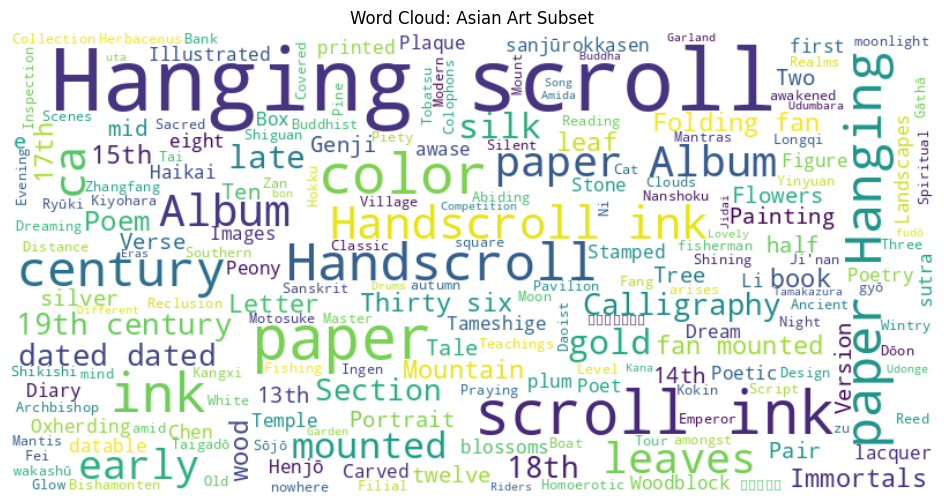

In [21]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#Relevant text fields
text_fields = df_asian_art[["Title", "Object Name", "Medium", "Object Date"]].fillna("")
combined_text = " ".join(df_asian_art[col].astype(str).str.cat(sep=" ") for col in text_fields.columns)

#Generate and display word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud: Asian Art Subset")
plt.show()


----------------------------------------SECTION 3 -------------------------------------------------

# Multi-layered queries

We may wish to layer queries for the API request, bundle a few different topics for finding patterns and such. We can browse the endpoint using the URL and assess what kinds of items we would like to collect, or pair a few keywords terms and go by that logic. In the query parameters we can also use boolean terms as we did earlier 'has Image'='true' and add further logic. Some APIs support multiple ways of communicating based on the dedicated documentation protocols, so no API will work exactly the same way. It is important to assess the parameters and available endpoints in the documentation. It is similar to formulating systematic literature search queries via varying tools in some ways.

It was not explicitly clear is Met API endpoint would allow multiple terms in a query.

Below we will run through a demonstrative example to combine a few different items/queries and see what we can output from there.

**Search 3**

In [ ]:
# These are some of the required imports for the session
import requests              # For sending HTTP requests to the API
import json                  # For working with JSON responses
from pathlib import Path     # For file/directory path handling
import pandas as pd          # For working with tabular data
import pprint                # For readable display of nested JSON objects and other printed items
import time                  # Adding time delay when we get data from the API
from collections import Counter #counting things
### we add this block here in case there is a kernel refresh as we go along in the session

In [ ]:
# the base URL for the Met Museum API --- and the version is noted
base_url = "https://collectionapi.metmuseum.org/public/collection/v1"

# Define the multi-term search query
search_3_query = "Japan, Samurai, Edo, Ink"

# Perform the search request --- above we defined the base and the search so the below line can incorporate 
#them in a succinct line.
search_3_response = requests.get(f"{base_url}/search", params={"q": search_3_query})

# Check response and parse object IDs
if search_3_response.status_code == 200:
    search_data_3 = search_3_response.json()
    object_ids_3 = search_data_3.get("objectIDs", []) or []
    print(f"Total results: {search_data_3.get('total', 0)}")
    print(f"First 10: {object_ids_3[:10]}")
else:
    print(f"potential errors: {search_3_response.status_code}")


Total results: 5302
First 10: [53449, 670908, 75747, 39799, 44918, 37145, 53446, 39664, 44858, 53410]


In [24]:
#Save Search 3 Object IDs JSON ---
metadata_dir = Path("Metadata")
search3_ids_path = metadata_dir / "search3_object_ids.json"
with open(search3_ids_path, "w", encoding="utf-8") as f:
    json.dump({"objectIDs": object_ids_3}, f, indent=2)

We take 50 to work with

In [ ]:
# directory
metadata_dir = Path("Metadata")

#Retrieve metadata from the Met API ---
search3_metadata = []
status_log = []

for idx, obj_id in enumerate(object_ids_3[:50], 1):
    obj_url = f"https://collectionapi.metmuseum.org/public/collection/v1/objects/{obj_id}"
    try:
        response = requests.get(obj_url, timeout=10)
        status = response.status_code
        status_log.append(f"{idx}/{len(object_ids_3)} — ID: {obj_id} — Status: {status}")
        ### Added some readability elements for the printout for us to review
        if status == 200:
            search3_metadata.append(response.json())
        else:
            continue
    except Exception as e:
        status_log.append(f"{idx}/{len(object_ids_3)} — ID: {obj_id} — Error: {e}")
    time.sleep(0.2)

# Print status log after all requests are complete
print("\n--- Status Log ---")
for line in status_log:
    print(line)
    
status_log_path = Path("Metadata") / "search3_status_log.txt"
with open(status_log_path, "w", encoding="utf-8") as f:
    f.write("\n".join(status_log))

### we simply take the first 50, there is no inherent order in the object id list, you can also specify
#ID if that is preferred. So this is simply the first 50 items.



--- Status Log ---
1/5302 — ID: 53449 — Status: 200
2/5302 — ID: 670908 — Status: 200
3/5302 — ID: 75747 — Status: 200
4/5302 — ID: 39799 — Status: 200
5/5302 — ID: 44918 — Status: 200
6/5302 — ID: 37145 — Status: 200
7/5302 — ID: 53446 — Status: 200
8/5302 — ID: 39664 — Status: 200
9/5302 — ID: 44858 — Status: 200
10/5302 — ID: 53410 — Status: 200
11/5302 — ID: 53408 — Status: 200
12/5302 — ID: 53422 — Status: 200
13/5302 — ID: 53456 — Status: 200
14/5302 — ID: 671023 — Status: 200
15/5302 — ID: 53457 — Status: 200
16/5302 — ID: 53010 — Status: 200
17/5302 — ID: 53427 — Status: 200
18/5302 — ID: 671056 — Status: 200
19/5302 — ID: 671024 — Status: 200
20/5302 — ID: 53222 — Status: 200
21/5302 — ID: 53219 — Status: 200
22/5302 — ID: 53241 — Status: 200
23/5302 — ID: 53221 — Status: 200
24/5302 — ID: 53429 — Status: 200
25/5302 — ID: 53439 — Status: 200
26/5302 — ID: 40468 — Status: 200
27/5302 — ID: 53441 — Status: 200
28/5302 — ID: 285902 — Status: 200
29/5302 — ID: 54871 — Status: 20

In [27]:
# Save metadata as JSON ---
search3_metadata_path = metadata_dir / "search3_metadata_batch.json"
with open(search3_metadata_path, "w", encoding="utf-8") as f:
    json.dump(search3_metadata, f, indent=2)

In [ ]:
# Load the saved metadata JSON
with open(search3_metadata_path, "r", encoding="utf-8") as f:
    loaded_metadata = json.load(f)

# Pretty print first 3 entries - pretty print is used to print things 'nicely' , it is a preference
for i, item in enumerate(loaded_metadata[:3], 1):
    print(f"\n--- Record {i} ---")
    print(json.dumps(item, indent=2))


--- Record 1 ---
{
  "objectID": 53449,
  "isHighlight": false,
  "accessionNumber": "2015.300.227a\u2013f",
  "accessionYear": "2015",
  "isPublicDomain": true,
  "primaryImage": "https://images.metmuseum.org/CRDImages/as/original/DP-13180-023.jpg",
  "primaryImageSmall": "https://images.metmuseum.org/CRDImages/as/web-large/DP-13180-023.jpg",
  "additionalImages": [
    "https://images.metmuseum.org/CRDImages/as/original/DP-13180-024.jpg",
    "https://images.metmuseum.org/CRDImages/as/original/DP-13180-025.jpg",
    "https://images.metmuseum.org/CRDImages/as/original/DP-13180-026.jpg",
    "https://images.metmuseum.org/CRDImages/as/original/DP-13180-027.jpg",
    "https://images.metmuseum.org/CRDImages/as/original/DP-13180-028.jpg"
  ],
  "constituents": [
    {
      "constituentID": 164764,
      "role": "Artist",
      "name": "Utagawa Hiroshige",
      "constituentULAN_URL": "http://vocab.getty.edu/page/ulan/500019641",
      "constituentWikidata_URL": "https://www.wikidata.org/

Let's add a few extra fields to expand on this output

Here, in an effort to create a richer set, we can add more of the available fields to populate our outputs

In [ ]:
metadata_dir = Path("Metadata")
converted_dir = Path("Converted_Data")

# Load the saved Search 3 metadata
search3_metadata_path = metadata_dir / "search3_metadata_batch.json"
with open(search3_metadata_path, "r", encoding="utf-8") as f:
    search3_metadata = json.load(f)

# Extract extended fields from each record
records = []
for item in search3_metadata:
    records.append({
        "Object ID": item.get("objectID"),
        "Title": item.get("title"),
        "Artist Name": item.get("artistDisplayName"),
        "Artist Gender": item.get("artistGender"),
        "Culture": item.get("culture"),
        "Country": item.get("country"),
        "Region": item.get("region"),
        "Subregion": item.get("subregion"),
        "Period": item.get("period"),
        "Dynasty": item.get("dynasty"),
        "Object Date": item.get("objectDate"),
        "Object Begin Date": item.get("objectBeginDate"),
        "Object End Date": item.get("objectEndDate"),
        "Medium": item.get("medium"),
        "Dimensions": item.get("dimensions"),
        "Object Name": item.get("objectName"),
        "Classification": item.get("classification"),
        "Department": item.get("department"),
        "Public Domain": item.get("isPublicDomain"),
        "Primary Image URL": item.get("primaryImageSmall"),
        "Object URL": item.get("objectURL")
    })

# Create DataFrame which allows us to work here easily and draw on data features.
df_search3 = pd.DataFrame(records)

# Save as CSV in our preferred directory
csv_path = converted_dir / "subset_data_search3.csv"
df_search3.to_csv(csv_path, index=False, encoding="utf-8-sig")

# Save as Pickle file (just a failsafe option)
pkl_path = metadata_dir / "subset_data_search3.pkl"
df_search3.to_pickle(pkl_path)

# Preview to take a look
print(f"{len(df_search3)} records from Search 3.")
print(df_search3.head())

50 records from Search 3.
   Object ID                                              Title  \
0      53449            Six Jewel Rivers from Various Provinces   
1     670908  Three Gods of Good Fortune Visit the Yoshiwara...   
2      75747  “Takebun,” from the Musical Drama “The New Pie...   
3      39799  Under the Wave off Kanagawa (Kanagawa oki nami...   
4      44918                                        Rough Waves   

          Artist Name Artist Gender Culture Country Region Subregion  \
0   Utagawa Hiroshige                 Japan                            
1     Chōbunsai Eishi                 Japan                            
2                                     Japan                            
3  Katsushika Hokusai                 Japan                            
4         Ogata Kōrin                 Japan                            

                   Period Dynasty  ... Object Begin Date  Object End Date  \
0  Edo period (1615–1868)          ...              1857     

We have something like this:

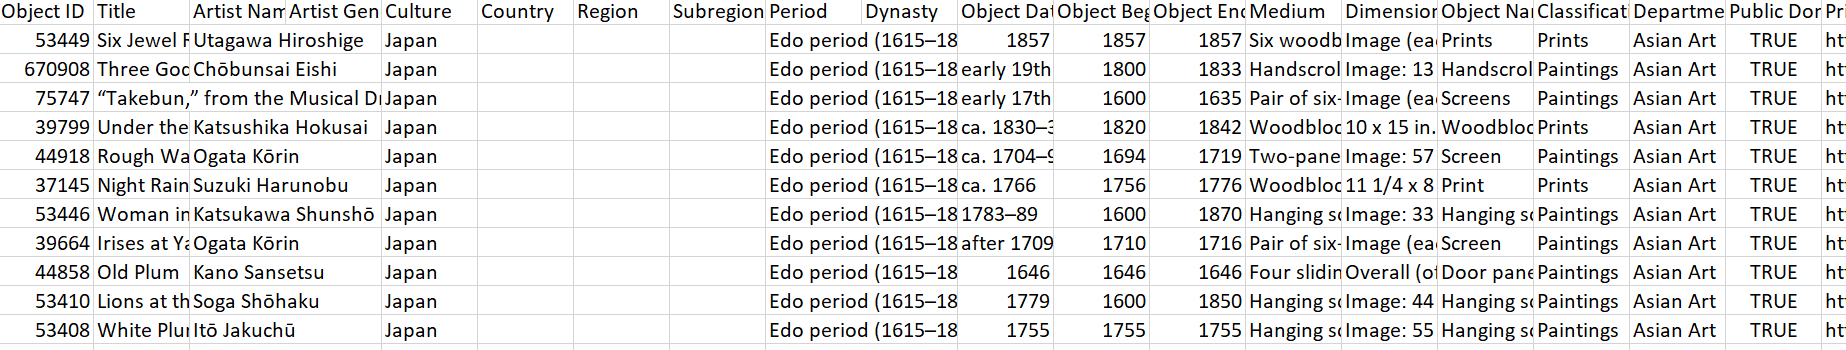

The multiple terms for search have worked effectively, allowing us to combine multiple items in the query to request object IDs, then associated metadata (after we reduced the size) - 5000 would have been far too much and we would have to set an iterative code block to add delays, fallbacks and other features to avoid blocks/crashes, and errors.

Accounting for delays, and looping back over available IDs even where status codes faltered is possible with logging and creating dataframes or lists to re-run through those if it is essential to capture as much as possible.

#### Taking a look at the data

We can plot a few things...

C:\Users\s2119622\AppData\Local\Temp\ipykernel_20196\3110583573.py:9: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


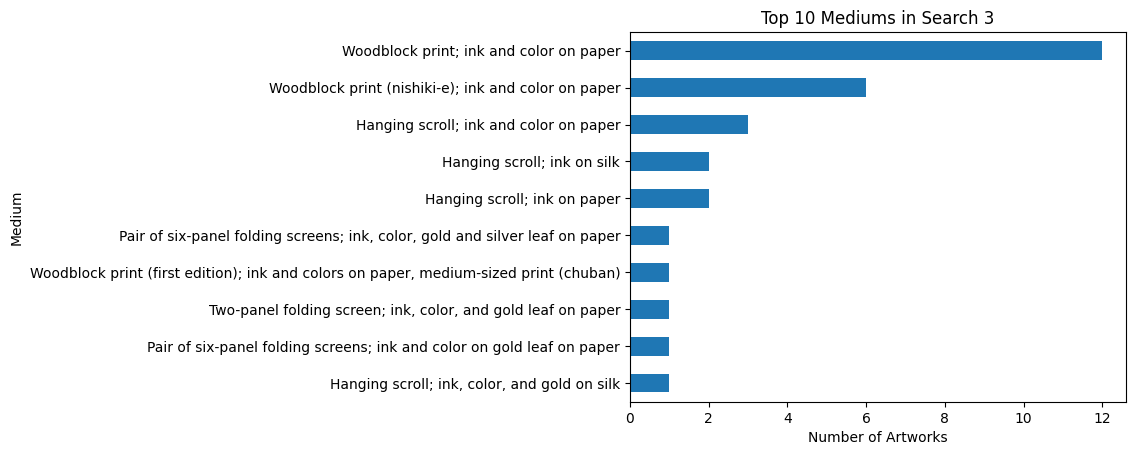

In [ ]:
import matplotlib.pyplot as plt

# Count top 10 mediums from search 3
df_search3['Medium'].value_counts().nlargest(10).plot(kind='barh')
plt.title("Top 10 Mediums in Search 3")
plt.xlabel("Number of Artworks")
plt.ylabel("Medium")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


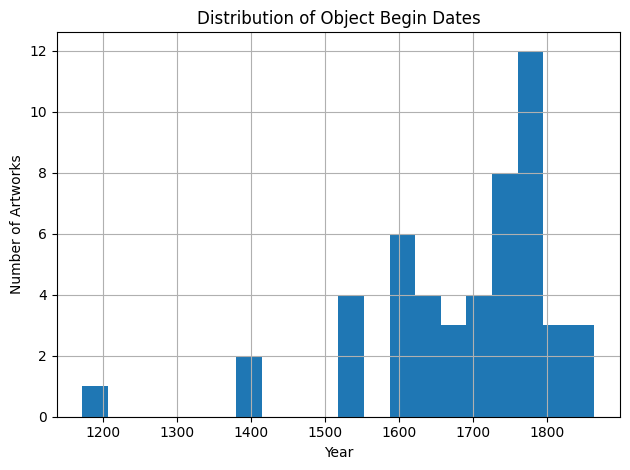

In [ ]:
# Histogram of object begin dates (does not include pre-1000 but a quick snapshot) - numerous options available
# depending on what you intend to investigate with the data.
df_search3['Object Begin Date'].hist(bins=20)
plt.title("Distribution of Object Begin Dates")
plt.xlabel("Year")
plt.ylabel("Number of Artworks")
plt.tight_layout()
plt.show()


In reality, a larger dataset would require cleaning and preprocessing to tangibly work with it

We can take a look at the overall shape, examine missing items and so forth...We have the data saved as a dataframe here so we can call and examine items

In [ ]:
# Basic overview to assess the data overall, its shape, length and dimensions (what do we have)
print("DataFrame Shape:", df_search3.shape)
print("\nColumn Names:", df_search3.columns.tolist())

# Count missing values per column - this handy if you want to work with only complete data or are interested
# in what is missing from a historical perspective for instance..
print("\nMissing Values Per Column:")
print(df_search3.isna().sum())

# Count unique values per column
print("\nUnique Values Per Column:")
print(df_search3.nunique())

# Quick value counts for select columns
print("\nTop Departments:")
print(df_search3['Department'].value_counts())
#Classifications was listed in the documentation for the Met, it is how the team there have grouped and classified certain objects.
print("\nTop Classifications:")
print(df_search3['Classification'].value_counts().head(10))


DataFrame Shape: (50, 21)

Column Names: ['Object ID', 'Title', 'Artist Name', 'Artist Gender', 'Culture', 'Country', 'Region', 'Subregion', 'Period', 'Dynasty', 'Object Date', 'Object Begin Date', 'Object End Date', 'Medium', 'Dimensions', 'Object Name', 'Classification', 'Department', 'Public Domain', 'Primary Image URL', 'Object URL']

Missing Values Per Column:
Object ID            0
Title                0
Artist Name          0
Artist Gender        0
Culture              0
Country              0
Region               0
Subregion            0
Period               0
Dynasty              0
Object Date          0
Object Begin Date    0
Object End Date      0
Medium               0
Dimensions           0
Object Name          0
Classification       0
Department           0
Public Domain        0
Primary Image URL    0
Object URL           0
dtype: int64

Unique Values Per Column:
Object ID            50
Title                50
Artist Name          35
Artist Gender         2
Culture      

That is a run through of a few things we have completed in this code book:

High level:
- Making an API request
- Collecting metadata (text and image)
- Assessing and recording workflow
- Status code tracking
- Retrieving larger sets of metadata (text)
- Carrying out a multi-term query

Specifics:
- Using the search endpoint of an API url to find items
- Adapting the URL endpoint to then retrieve metadata
- Working with the JSON file to subset and extract items
- Converting subsets of data to csv for local working 
- Extracting images from available URLs which have open rights for access
- Understanding documentation parameters for requests to API
- Working with extracted and exported data briefly
- Examining varying possibilities with a REST - web API
- Understanding status codes and comparing home vs institution IP.



